# Spike Notebook

a simplified environment for processing Bruker NMR datasets with `SPIKE`.

# Reading and handling processed data from Topspin

***Usage***

- This notebook contains a series of short recipes which can be used to read TopSpin processed datasets, and continue to work  with them 

## Initialization
the following cell is to be run once, at the beginning of the processing

## STARTING Environment...


          SPIKE
    Version     : 0.99.32
    Date        : 08-02-2023
    Revision Id : 586

loading plugins... ( use spike.plugins.report() for a short description of each plugins )
*** zoom3D not loaded ***
generic plugins loaded:
Fitter,  Linear_prediction,  Peaks,  bcorr,  fastclean,  gaussenh,  rem_ridge,  sane,  sg,  test,  urQRd, 
user plugins loaded:
msapmin, 
*** load_dump not loaded ***
NMR plugins loaded:
Bruker_NMR_FT,  Bucketing,  Integrate,  PALMA,  apmin, 
MS plugins loaded:
FTMS_calib,  PhaseMS,  diagonal_2DMS, 

Interactive module version, 1.3.0


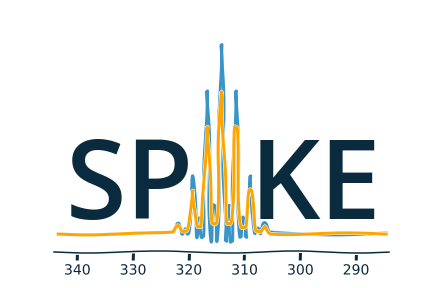

Run date: 2023-03-24T15:20:04.659325


## ...program is Ready

In [2]:
# load all python and interactive tools - has to be run only once (but it does not hurt to rerun...)
from IPython.display import display, HTML, Markdown, Image
display(Markdown('## STARTING Environment...'))
import json
import matplotlib as mpl
%matplotlib widget
import spike
from spike.Interactive import INTER as I
from spike.Interactive import INTER_2D as I2D
from spike.Interactive.ipyfilechooser import FileChooser
from datetime import datetime
I.initialize()
print('Run date:', datetime.now().isoformat() )
display(Markdown('## ...program is Ready'))
from importlib import reload  # this line is debugging help

# configurable items - you may change them to fit you preferences
verbose = 1                              # chose from 0 (terse) to 3 more verbose
mpl.rcParams['figure.figsize'] = (8,4)   # (X,Y) default figure size
I.Activate_Wheel = True                  # True/False    scale with wheel control in the graphic cells 
I.reverse_scroll = False                 # inverse the direction of the mouse wheel, whether it is `True` (TrackPad) or `False` (Mouse)
I.ParamList = ['SOLVENT', 'PULPROG', 'SFO1', 'NS', 'TE', 'TD', 'RG', 'SW', 'O1', 'D1','P1']    # the list of important parameters to display

### Choose the file
The `FileChooser()` tool creates a dialog box which allows to choose a file on your disk

- use the `Select` button, click on the directory to move around `..` is for going back in the directory tree
- click on the file to select it
- modify the ( *optional* ) `path` argument, to start the exploration on a given location
- changing `path='/DATA/'` to `path='.'` will start the browsing from the current directory 
- After the selection, the selected filename is found in `FC.selected`

# Importing regular 2rr TopSpin files

In [3]:
# FileChooser
FC = FileChooser(path='/DATA',filename='2rr')
display(FC)

FileChooser(path='/DATA', filename='2rr', show_hidden='False')

### Import  & display


In [6]:
from spike.File.BrukerNMR import Import_2D_proc

print('Reading file ',FC.selected)
d1 = Import_2D_proc(FC.selected)       # creates a SPIKE NMRData object, from which everything is available
display(I.summary(d1, output='HTML')) 
d1.set_unit('ppm')

Reading file  /DATA/HSQC_600/pharma_151201/13/pdata/1/2rr


2D data-set
Axis F1 :NMR axis at 150.914064 MHz, 512 complex pairs,  from 49.583760 ppm (7482.886711 Hz) to 99.583760 ppm  (15028.589892 Hz)
Axis F2: NMR axis at 600.132881 MHz, 2048 complex pairs,  from -0.206880 ppm (-124.155434 Hz) to 9.806928 ppm  (5885.459951 Hz)
data-set is hypercomplex (order 2)

Show2D(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Positive', layout=Layout(widt…

/home/mad/miniconda3/envs/OW/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


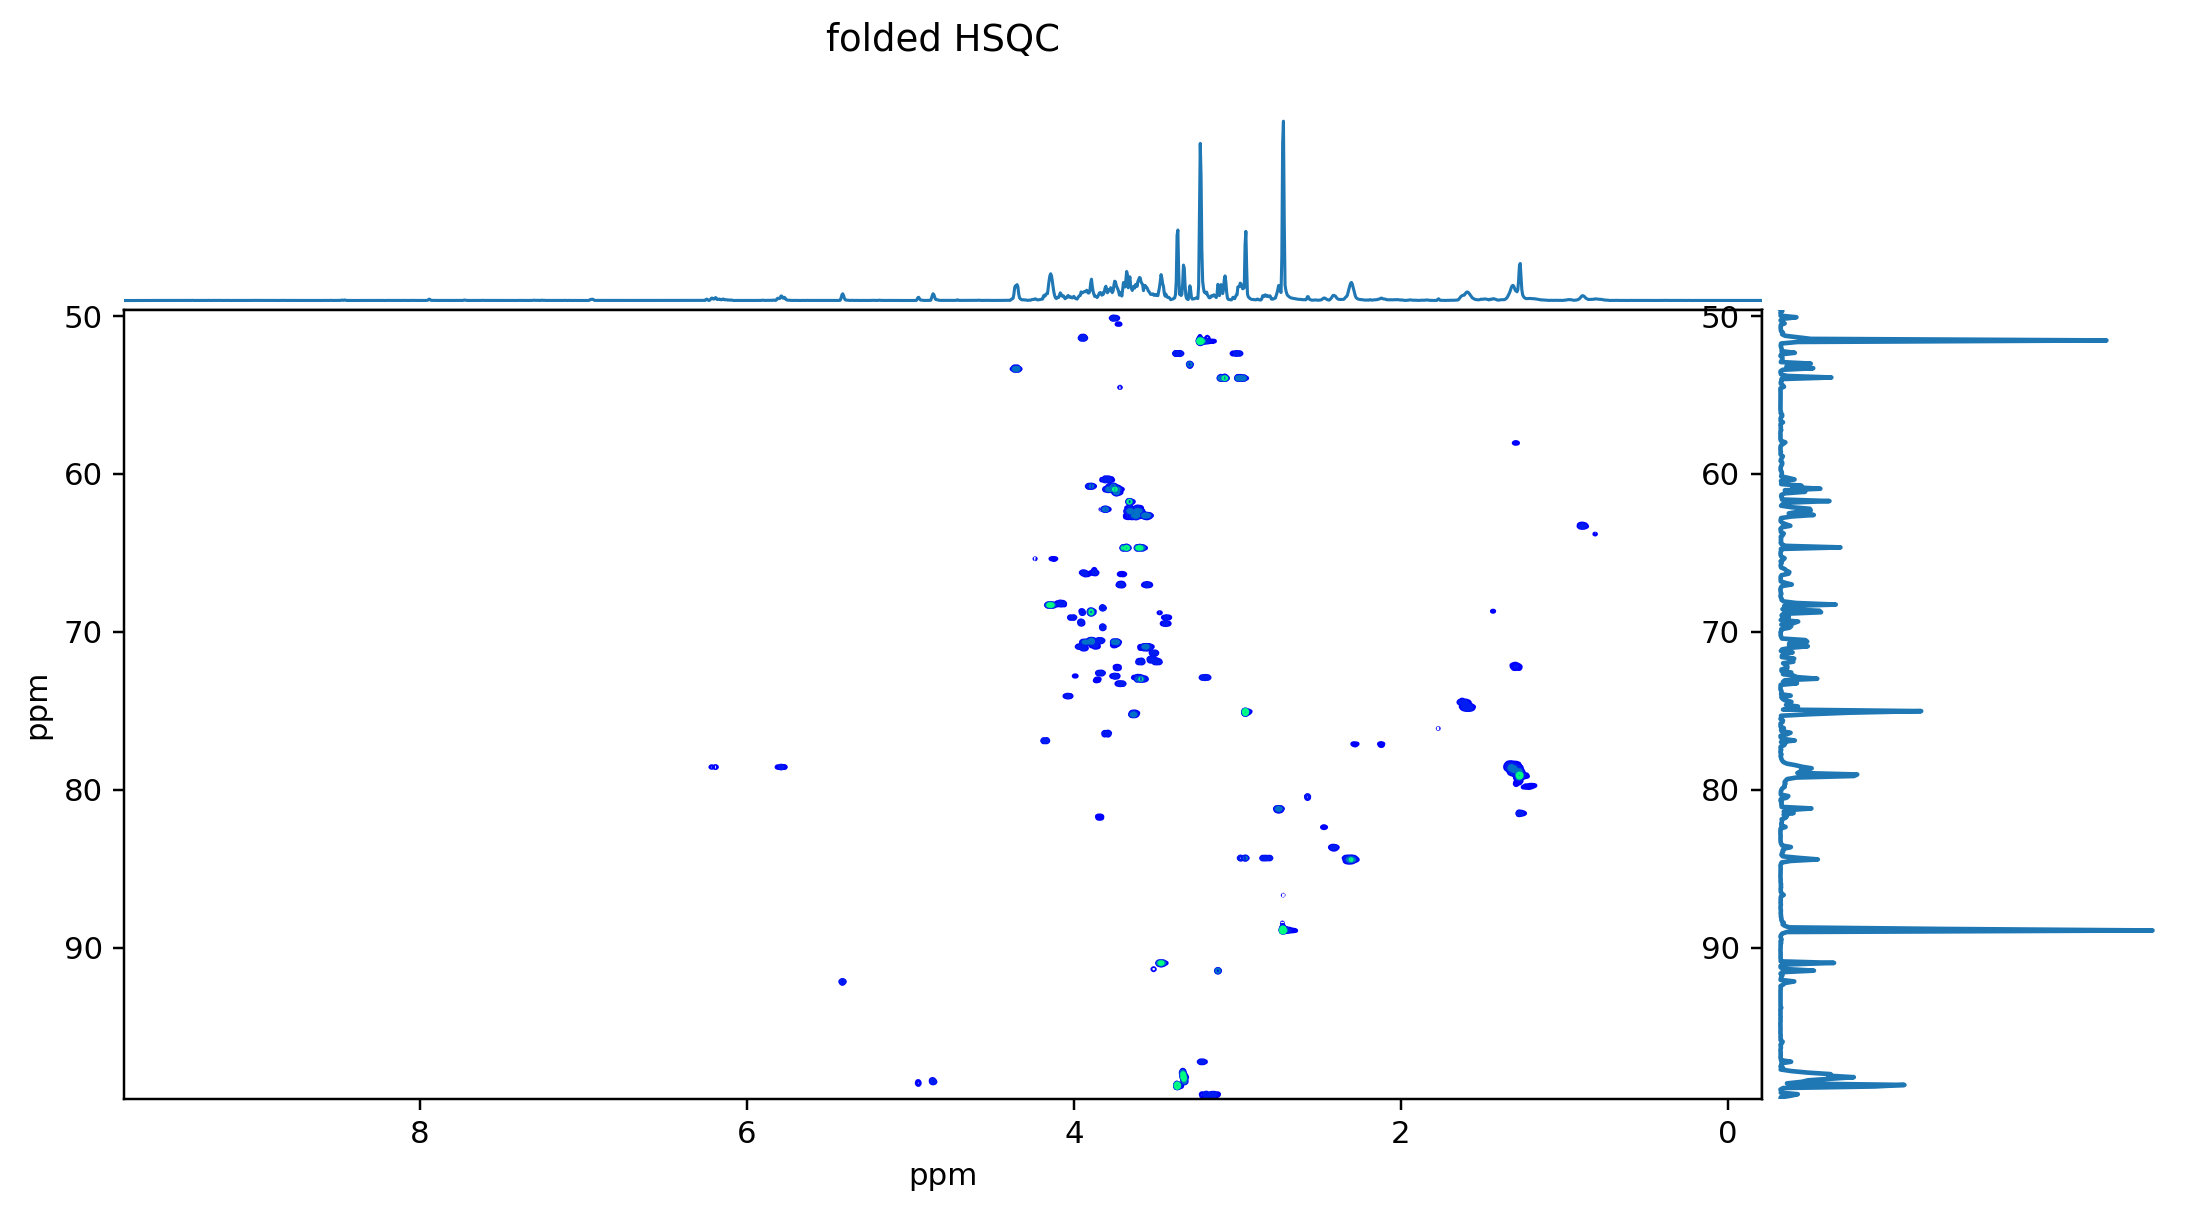

In [23]:
S2 = I2D.Show2D(d1, title=d1.params['acqu']['title'])
S2.scale.value=5
S2

---
# Storing to open format

Several possibilities

### to native Spike/Gifa file format
- binary for data / with axes description
- json for spectrometer metadata

In [15]:
d1.save('my_file.gs2')
with open('my_file.json','w') as Meta:
    json.dump(d1.params, Meta)

writing 2D


The file with recovered as follow:

2D data-set
Axis F1 :NMR axis at 150.914064 MHz, 512 complex pairs,  from 49.583760 ppm (7482.886711 Hz) to 99.583760 ppm  (15028.589892 Hz)
Axis F2: NMR axis at 600.132881 MHz, 2048 complex pairs,  from -0.206880 ppm (-124.155434 Hz) to 9.806928 ppm  (5885.459951 Hz)
data-set is hypercomplex (order 2)

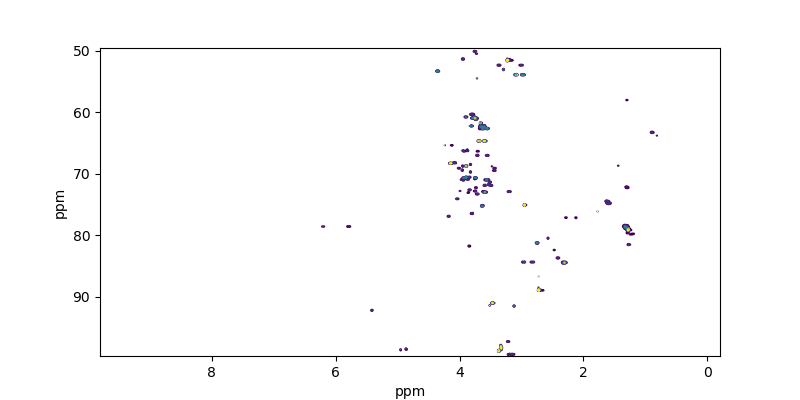

In [24]:
rec1 = spike.NMR.NMRData(name='my_file.gs2')   # data
with open('my_file.json','r') as Meta:         # and metadata
    rec1.params = json.load(Meta)
# verify
display(I.summary(rec1, output='HTML')) 
rec1.set_unit('ppm')
rec1.display(scale=5)

### to numpy format



In [28]:
import numpy as np
mybuff = d1.get_buffer()   # get_buffer() conserves real/imaginary state - in the case of hypercomplex data - as here - real and imagniary part in F1 are interleaved
np.save('my_file_buffer',mybuff)   # extention .npy is added
# alternatively, use the compresse data format:
np.savez_compressed('my_file_buffer',[mybuff])   # extention .npz is added

The file is recovered as follows:

***but all metadata are lost*** (400Mhz is the frequency by  default !)

2D data-set
Axis F1 :NMR axis at 400.000000 MHz, 512 complex pairs,  from 0.000000 ppm (0.000000 Hz) to 15.707963 ppm  (6283.185307 Hz)
Axis F2: NMR axis at 400.000000 MHz, 2048 complex pairs,  from 0.000000 ppm (0.000000 Hz) to 15.707963 ppm  (6283.185307 Hz)
data-set is hypercomplex (order 2)

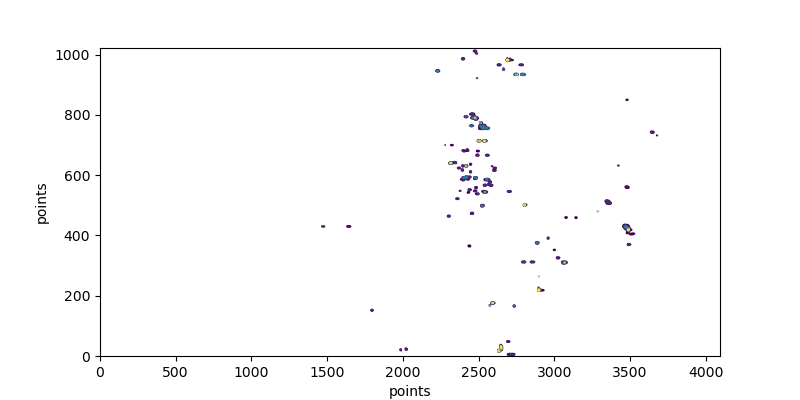

In [38]:
recbuff = np.load('my_file_buffer.npy')
rec2 = spike.NMR.NMRData(buffer=recbuff)
rec2.axis1.itype=1   # force complex in F1
rec2.display(scale=5)

recovering the meta data - inspired from spike.File.BrukerNMR

2D data-set
Axis F1 :NMR axis at 150.914064 MHz, 512 complex pairs,  from 49.583760 ppm (7482.886711 Hz) to 99.583760 ppm  (15028.589892 Hz)
Axis F2: NMR axis at 600.132881 MHz, 2048 complex pairs,  from -0.206880 ppm (-124.155434 Hz) to 9.806928 ppm  (5885.459951 Hz)
data-set is hypercomplex (order 2)

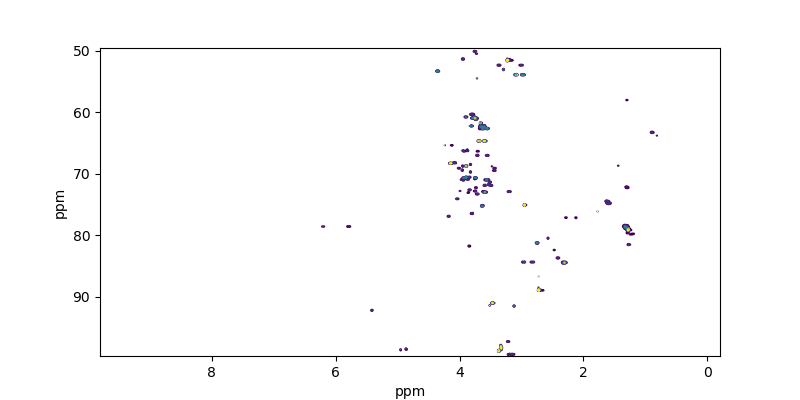

In [42]:
from spike.File.BrukerNMR import offset, zerotime
# read json
with open('my_file.json','r') as Meta:         # and metadata
    META = json.load(Meta)
rec2.params = META

# then restore axes
rec2.axis1.frequency = float(META['acqu2']['$SFO1'])
try:
    rec2.axis1.specwidth = float(META['acqu2']['$SW_h'])
except KeyError:    # this happens on certain versions
    rec2.axis1.specwidth = float(META['acqu2']['$SW'])*d.axis1.frequency
rec2.axis2.specwidth = float(META['acqu']['$SW_h'])
rec2.axis2.frequency = float(META['acqu']['$SFO1'])
rec2.frequency = rec2.axis2.frequency
rec2.axis1.offset = offset(META['acqu2'], META['proc2'])
rec2.axis2.offset = offset(META['acqu'], META['proc'])
rec2.axis2.zerotime = zerotime(META['acqu'])

# verify
display(I.summary(rec2, output='HTML')) 
rec2.set_unit('ppm')
rec2.display(scale=5)

-----
# Importing DOSY from Topspin
DOSY have a different format in Spike, so the import is different

In [43]:
from spike.plugins.NMR.PALMA import Import_DOSY, Import_DOSY_proc

# FileChooser
FCD = FileChooser(path='/DATA',filename='2rr')
display(FCD)

FileChooser(path='/DATA', filename='2rr', show_hidden='False')

In [72]:
print('Reading file ',FCD.selected)
ddosy = Import_DOSY_proc(FCD.selected, postprocessed=True)       # the flag postprocessed determines state in F1    False: after XF2,   True: when fully processed
display(I.summary(ddosy, output='HTML')) 

Reading file  /home/mad/Documents/ mad/cours/AISD/NNB/CAS170223/8/pdata/1000/2rr
DOSY performed on 1H
ste
0.002 0.09617750000000001 0.0004 ste 1H


/home/mad/Documents/spike/spike/Interactive/INTER_2D.py:225: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  self.spec_ax.clear()


Show2D(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Positive', layout=Layout(widt…

/home/mad/miniconda3/envs/OW/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


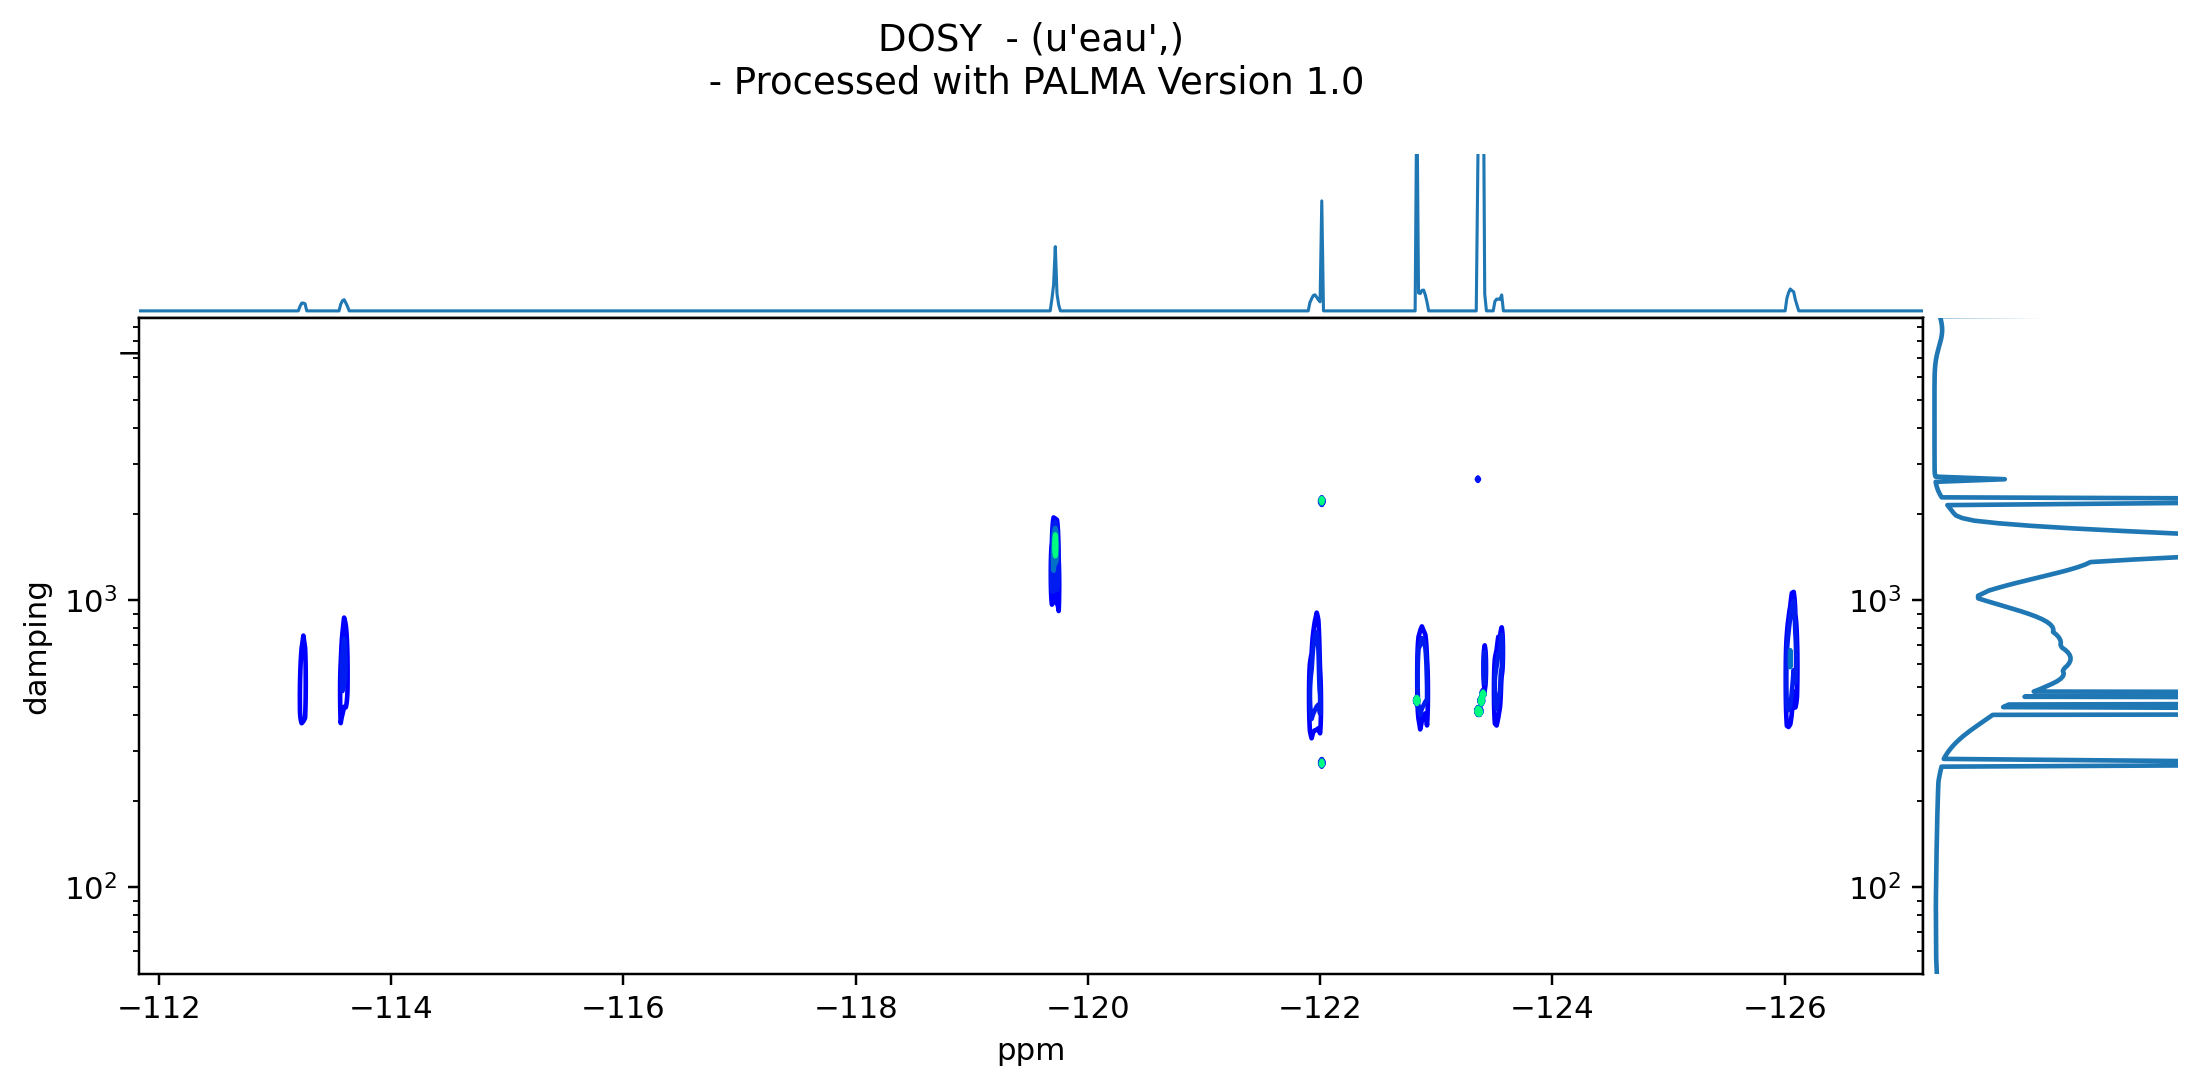

In [73]:
ddosy.axis2.currentunit = 'ppm'
SD = I2D.Show2D(ddosy, title=ddosy.params['acqu']['title'])
SD.scale.value=5
SD

In [75]:
ls -lh my_file*

-rw-rw-r-- 1 mad mad 33M mars  24 15:34 my_file_buffer.npy
-rw-rw-r-- 1 mad mad 15M mars  24 15:34 my_file_buffer.npz
-rw-rw-r-- 1 mad mad 17M mars  24 15:26 my_file.gs2
-rw-rw-r-- 1 mad mad 18K mars  24 15:26 my_file.json
-rw-rw-r-- 1 mad mad 33M mars  24 15:33 my_file.npy


--------------